In [148]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import scipy as sp

$ F(x) = \frac{I^2}{2} \cdot \frac{\partial L}{\partial x}$

Sendo,

$L = \frac{N^2}{R}$

e 

$R = \frac{l_{méd}}{\mu \cdot A_{entreferro}}$


Substituindo os valores fornecidos, tem-se a seguinte expressão para a indutância

$L = \frac{1,265 \cdot 10^{-3}}{x^2} \hspace{5mm} H$

Asssim, obtém-se o seguinte expressão para a força

$ F = \frac{-2,53 \cdot 10^{-4}}{x^2} $


In [149]:
pos = np.arange(0.001, 0.20, 0.001)
f = -2.53e-2/pos**2

In [150]:


H = np.array([0,
              68,
              135,
              203,
              271,
              338,
              406,
              474,
              542,
              609,
              1100,
              1500,
              2500,
              4000,
              5000,
              9000,
              12000,
              20000,
              25000])

B = np.array([0,
              0.733,
              1.205,
              1.424,
              1.517,
              1.560,
              1.588,
              1.617,
              1.631,
              1.646,
              1.689,
              1.703,
              1.724,
              1.731,
              1.738,
              1.761,
              1.770,
              1.80,
              1.816])

func = interp1d(B, H, kind='cubic')
B_pnts = np.arange(0, 1.8, 1.8/100)
H_it = func(B_pnts)

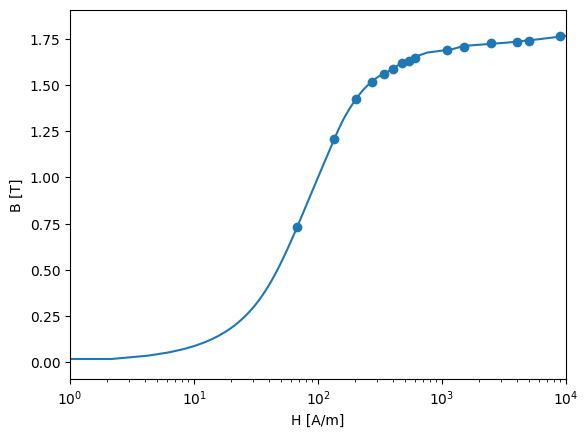

In [151]:
plt.ylabel('B [T]')
plt.xlabel('H [A/m]')
plt.xlim([1, 1e4])
plt.xscale('log')
plt.scatter(H, B)
plt.plot(H_it, B_pnts)
plt.show()

In [152]:
x = np.arange(0, 0.1)
N = 1000
A = 16e-4

w_per_vol = sp.integrate.trapezoid(H_it, B_pnts)
f_real = w_per_vol * 0.7

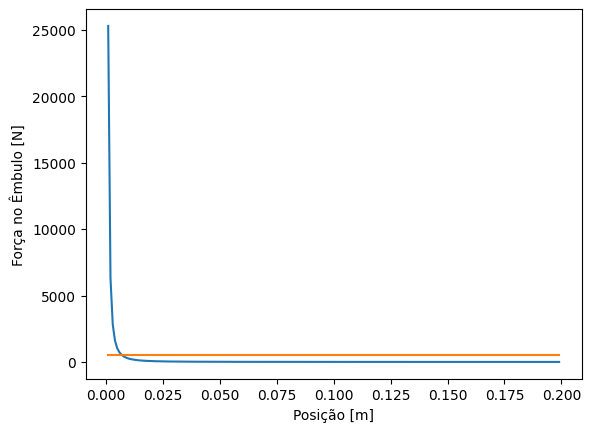

In [153]:
plt.ylabel('Força no Êmbulo [N]')
plt.xlabel('Posição [m]')
plt.plot(pos, f*-1)
plt.plot(pos, np.repeat(f_real, len(pos)))
plt.show()